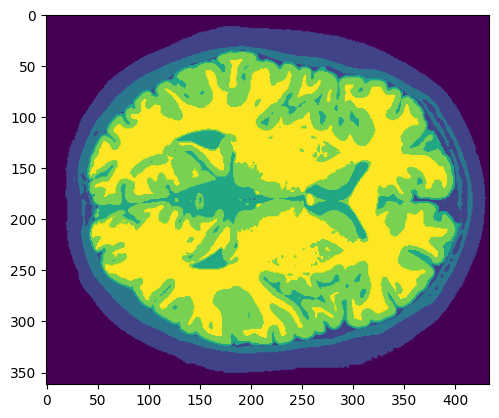

In [2]:
# Importing necessary libraries
import utils
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes, binary_dilation
from skimage.morphology import binary_opening, binary_closing, disk
from skimage.morphology import convex_hull_image
from skimage.feature import canny

import scipy.io
import scipy.ndimage as ndimage
from sklearn.cluster import KMeans

import numpy as np
import matplotlib.pyplot as plt



def binarizing_cleaning(reference_img):
    # Apply an Otsu algorithm to the reference image to obtain a binary mask
    threshold = threshold_otsu(reference_img)
    binary = reference_img > threshold - 0.02

    # Remove smaller artifacts (holes and objects) from the binary mask
    cleaned = remove_small_holes(binary)
    cleaned = remove_small_objects(cleaned, min_size=1000)

    return cleaned


def four_mask_labeling(cleaned, temporal_masks):
    # Apply a two-pass algorithm to the cleaned image to obtain preliminary labels
    labels, _ = ndimage.label(cleaned)

    # Save the first label as temporal mask "1"
    temporal_masks["1"] = (labels == 1).astype(int)

    # Invert the cleaned image
    inverted = ~cleaned

    # Apply the two-pass algorithm to the inverted image to obtain additional labels
    inverted_labels, _ = ndimage.label(inverted)

    # Keep only the first two labels and set all others to zero
    inverted_labels[inverted_labels > 2] = 0

    # Save the labels as temporal masks "0" and "2"
    temporal_masks["0"] = (inverted_labels == 1).astype(int)
    temporal_masks["2"] = (inverted_labels == 2).astype(int)

    # Create a temporary internal region mask by combining masks "0", "1", and "2"
    tmp_mask = temporal_masks["0"] + temporal_masks["1"] + temporal_masks["2"]
    temporal_masks["tmp_internal_region"] = (tmp_mask == 0).astype(int)

    return temporal_masks

def internal_mask_refinement_edges(temporal_masks, reference_img):
    # Get the edges from the masked internal region using the Canny edge detection algorithm
    edges = canny(reference_img * temporal_masks["tmp_internal_region"])

    # Dilate the edges
    edges = binary_dilation(edges)

    # Fill holes in the edges
    binary_mask = ndimage.binary_fill_holes(edges)

    # Remove small objects from the binary mask
    binary_mask = remove_small_objects(binary_mask, min_size=100)

    # Update the temporal mask for the internal region
    temporal_masks["tmp_internal_region"] = binary_mask

    return binary_mask, temporal_masks

def internal_mask_refinement_convex_hull(temporal_masks):
    # Apply the convex hull to the tmo_internal_region
    binary_mask = convex_hull_image(temporal_masks["tmp_internal_region"])

    # Save the convex hull mask in the temporal masks
    temporal_masks["tmp_internal_region"] = binary_mask.astype(int)

    return binary_mask, temporal_masks

# NOTE: This function is used to create the 3D edge-based fusion channel
def edge_fusion_channel_internal_refinement(temporal_masks, reference_img):

    # Dilation of the tmp_internal_region
    selem = disk(3)

    # Apply canny edge detection to the tmp_internal_region to each slice
    edges = np.zeros_like(temporal_masks["tmp_internal_region"])
    for i in range(temporal_masks["tmp_internal_region"].shape[2]):

        dilated = binary_dilation(temporal_masks["tmp_internal_region"][:,:,i], selem)

        # Apply the tmp_internal_region to the reference image
        internal_region = reference_img[:,:,i] * dilated

        edges[:,:,i] = canny(internal_region, sigma=3)

    # Aggregation of the edges
    aggregated_edges = np.sum(edges, axis=2) > 0

    # Fill the holes of the aggregated edges
    filled_aggregated_edges = ndimage.binary_fill_holes(aggregated_edges)


    # Extend one dimension and repeat the mask to all the slices
    filled_aggregated_edges = filled_aggregated_edges[:, :, np.newaxis]

    # Save the temp internal region
    temporal_masks["tmp_internal_region"] = filled_aggregated_edges

    return filled_aggregated_edges, temporal_masks

# NOTE: This function is used to create the 3D weighted fusion channel
def weighted_masked_internal_region(masked_internal_region):
    # Prepare an empty array to hold the weighted averages
    weighted_averages = np.empty(masked_internal_region.shape)

    for i in range(10):
        # Get current weights
        current_weights = utils.create_normal_distribution_mask(length=10, center_index=i, std=0.5)
        
        # Calculate the weighted average for the current set of 3 channels
        weighted_avg = np.tensordot(masked_internal_region, current_weights, axes=([2], [0]))
        
        # Assign the weighted average to the corresponding channels in the output
        weighted_averages[:, :, i] = weighted_avg

    weighted_averages += masked_internal_region

    # Normalize the weighted averages
    weighted_averages = (weighted_averages - weighted_averages.min()) / (weighted_averages.max() - weighted_averages.min())

    return weighted_averages


def kmeans_segmentation(image, n_clusters=4):
    # Reshape the image to a 2D array
    X = image.reshape(-1, 1)

    # Fit KMeans to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

    # Predict the labels for the data
    labels = kmeans.predict(X)

    # Reshape the labels to the original image shape
    labels = labels.reshape(image.shape)

    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_

    # Order the centroids and return the indices
    order = np.argsort(centroids, axis=0)

    return labels, order

def internal_mask_labeling(temporal_masks, reference_img, weighted_mask = False):
    # Apply the temporary internal region mask to the reference image
    masked_internal_region = reference_img * temporal_masks['tmp_internal_region']

    # Apply the weighted mask to the masked internal region
    # NOTE: This step is to apply the Weighed Fusion Channel to the internal region
    # to enhance the contrast of the internal region in 3d cases
    if weighted_mask:
        masked_internal_region = weighted_masked_internal_region(masked_internal_region)

    # Apply k-means clustering to the masked internal region to obtain labels
    internal_labels, order = kmeans_segmentation(masked_internal_region, n_clusters=4)

    # Use the order to assign labels to masks "3", "4", and "5"
    temporal_masks["3"] = (internal_labels == order[1]).astype(int)
    temporal_masks["4"] = (internal_labels == order[2]).astype(int)
    temporal_masks["5"] = (internal_labels == order[3]).astype(int)

    # Refine mask "2" by considering all other masks
    # NOTE: There are certain difference between the convex hull 
    # and the internal region, which consequently affect the
    # mask 2. Then, I need to refine it.
    tmp_mask = (temporal_masks["0"] + temporal_masks["1"] +
                temporal_masks["3"] + temporal_masks["4"] +
                temporal_masks["5"])
    temporal_masks["2"] = (tmp_mask == 0).astype(int)

    return temporal_masks


def mask_1_2_refinement(reference_img, temporal_masks, constant=0.075):
    # Combine masks "1" and "2" into a temporary mask
    # NOTE: In the ground trues, the mask 1 and 2 have some
    # irregularities (overlaps) in between each other. 
    # Then, I need to refine these two masks
    tmp_mask = temporal_masks["1"] + temporal_masks["2"]

    # Apply the temporary mask to the reference image
    tmp_masked = reference_img * tmp_mask

    # Apply Otsu algorithm to the masked image with a constant threshold adjustment
    # NOTE: I add some constant value to shift the threshold
    # because although the approximation of otsu is good, it
    # is doesn't achieve to take into account the irregularities
    threshold = threshold_otsu(tmp_masked)
    binary = tmp_masked > threshold - constant

    # Update the refined masks "1" and "2" in the temporal masks
    temporal_masks["1"] = binary.astype(int)
    temporal_masks["2"] = tmp_mask - binary
    
    return temporal_masks

# Loading data from a MATLAB file
data = scipy.io.loadmat('Brain.mat')
mri_stacked = data['T1']
mri_labels = data['label']

# Extracting the first slice of the MRI image and its corresponding labels
# NOTE: Just assign the whole stack for 3D cases
reference_img = mri_stacked[:,:,0]
reference_labels = mri_labels[:,:,0]

# Normalizing the reference image
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

# Dictionary to store temporal masks
temporal_masks = {}

# 1. Applying binarizing and cleaning to the reference image
cleaned = binarizing_cleaning(reference_img)

# 2. Applying four mask labeling to the cleaned image
temporal_masks = four_mask_labeling(cleaned, temporal_masks)

# 3. Refining the internal mask using edge detection
# NOTE: 2D cases: For testing the other alternative (convex hull), 
# just replace by the function here
binary_mask, temporal_masks = internal_mask_refinement_edges(temporal_masks, reference_img)
# binary_mask, temporal_masks = internal_mask_refinement_convex_hull(temporal_masks)

# NOTE: 3D cases: For testing the 3D edge-based fusion channel, just replace by the function here
# binary_mask, temporal_masks = internal_mask_refinement_convex_hull(temporal_masks)
# binary_mask, temporal_masks = edge_fusion_channel_internal_refinement(temporal_masks, reference_img)

# 4. Applying internal mask labeling to the temporal masks
temporal_masks = internal_mask_labeling(temporal_masks, reference_img)

# NOTE: for applying the weighted fusion channel, just set the weighted_mask to True
# temporal_masks = internal_mask_labeling(temporal_masks, reference_img, weighted_mask=True)

# 5. Refining masks "1" and "2" using the reference image
temporal_masks = mask_1_2_refinement(reference_img, temporal_masks)

# Generating the final segmented image using the temporal masks
segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks)

# NOTE: To get an slice from the 3D cases, just use the following line
# segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks, slice_index=0)

# Plotting the segmented image
plt.imshow(segmented_img)
plt.show()